# Notebook for development of spectroscopic retrieval package FROSTIE

In [1]:
# import area

import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.style
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
from matplotlib.ticker import MultipleLocator, AutoLocator, FormatStrFormatter, FuncFormatter, ScalarFormatter, NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import display, Math
from scipy.interpolate import interp1d
from frostie import retrieval, utils
from pyhapke import rad_tran, op_cons 
import pyhapke.utils
import pickle
import pandas as pd
from importlib import reload
import random
import warnings
from pandexo.engine import bintools
from multiprocessing import Pool
import dynesty
from dynesty import NestedSampler
from dynesty.utils import resample_equal
from dynesty import plotting as dyplot
from time import time
import corner
from scipy.stats import gaussian_kde
from decimal import Decimal

### Find a sampling scheme that uniformly samples abundances $X_i$ under the constraint that $\sum X_i = 1$.

### Experiment with a three component model

### 1. Sample $X_1$ and $X_2$ uniformly and set $X_3 = 1 - X_1 - X_2$

<IPython.core.display.Javascript object>


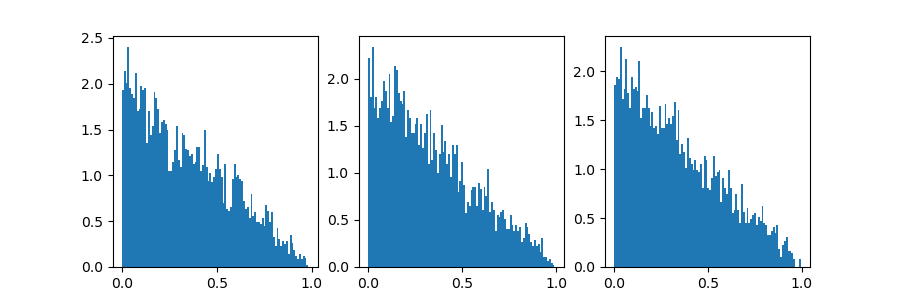

In [3]:
x1_list = []
x2_list = []
x3_list = []

for i in range(10000):
    x1 = np.random.random_sample()
    x2 = np.random.random_sample()
    
    if (x1 + x2) < 1:
        x3 = 1 - (x1 + x2)
        x1_list.append(x1)
        x2_list.append(x2)
        x3_list.append(x3)
        

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3))

ax[0].hist(x1_list,bins=100, density=True)
ax[1].hist(x2_list,bins=100, density=True)
ax[2].hist(x3_list,bins=100, density=True);



When done using Jeffery's prior (log-uniform):

<IPython.core.display.Javascript object>


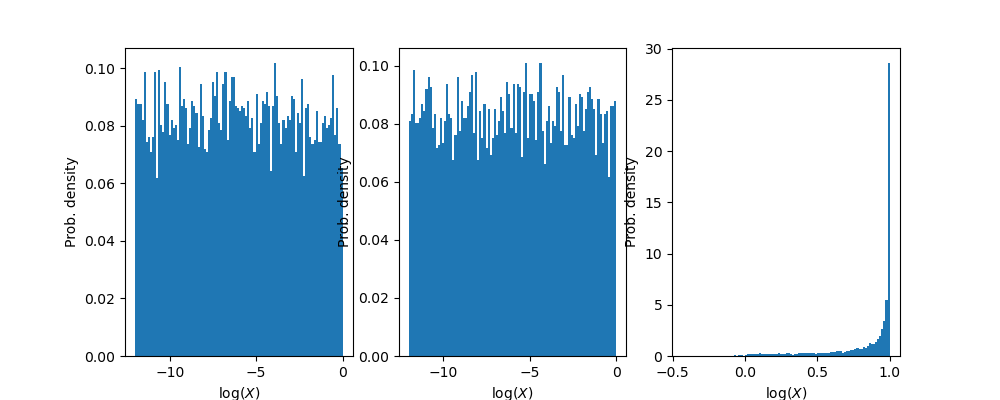

In [4]:
logx1_list = []
logx2_list = []
logx3_list = []

for i in range(10000):
    logx1 = 12*np.random.random_sample() - 12
    logx2 = 12*np.random.random_sample() - 12
    #z3 = np.random.random_sample()
    
    if (10**logx1 + 10** logx2) < 1:
        logx3 = 1 - np.exp(logx1) - np.exp(logx2)

 
        logx1_list.append(logx1)
        logx2_list.append(logx2)
        logx3_list.append(logx3)
        

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

ax[0].hist(logx1_list,bins=100,density=True)
ax[1].hist(logx2_list,bins=100,density=True)
ax[2].hist(logx3_list,bins=100,density=True)
ax[0].set_xlabel('log$(X)$')
ax[0].set_ylabel('Prob. density')
ax[1].set_xlabel('log$(X)$')
ax[1].set_ylabel('Prob. density')
ax[2].set_xlabel('log$(X)$')
ax[2].set_ylabel('Prob. density');

Why does this bias occur?

### 2. Sample X1, X2 and X3 uniformly and convert the values to center-log-transform numbers

Formulation from http://www.sediment.uni-goettingen.de/staff/tolosana/extra/CoDaNutshell.pdf

Theory from section 2.3.5 of [Benneke and Seager (2012)](https://iopscience.iop.org/article/10.1088/0004-637X/753/2/100/pdf):

For a mixture of $n$ components, the centered-log-ratio transformation of the $i$-th molecular species is defined as:


$$z_i = \textrm{clr}(X_i) = \textrm{ln}\dfrac{X_i}{g(\boldsymbol{x})}$$

where 

$$g(\boldsymbol{x}) = \left(\prod_{j=1}^{n} X_i \right)^{1/n} = \textrm{exp}\left(\dfrac{1}{n}\sum_{j=1}^{n}\textrm{ln}X_i\right)$$

A fully permutation-invariant description is obtained by using the centered-log-ratio transformed mixing ratios $z_1$ ...$z_{n−1}$ as the free parameters and assigning a uniform prior for all vectors in the $z$ -space. $z_n$ is obtained through the constraint that $\sum z_i = 0$

After sampling $z_i$, we can get $x_i$ through the transformation equation:

$$x_i = \dfrac{\textrm{exp}(z_i)}{\sum \textrm{exp}(z_i)}$$

<IPython.core.display.Javascript object>


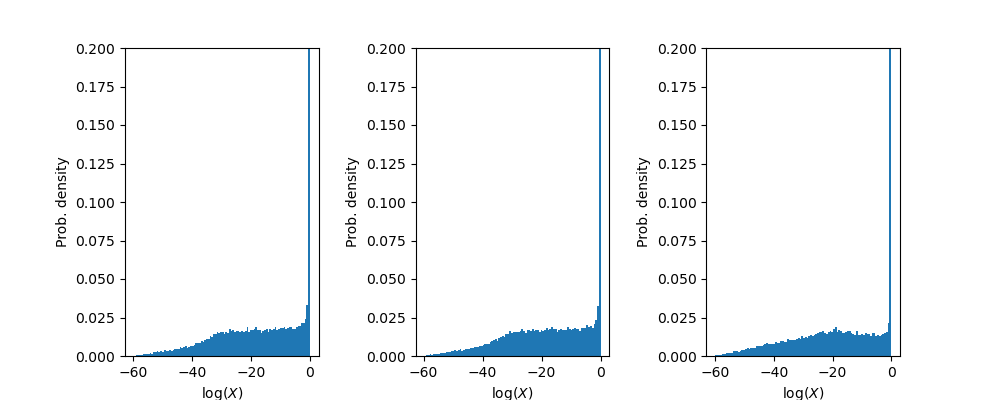

In [5]:
# centered log-ratio transform

x1_list = []
x2_list = []
x3_list = []


lim = 20


for i in range(50000):
    z1 = 2*lim*np.random.random_sample() - lim
    z2 = 2*lim*np.random.random_sample() - lim
    #z3 = np.random.random_sample()
    z3 = 0 - z1 - z2

    g = np.exp(z1) + np.exp(z2) + np.exp(z3)
    
    x1 = np.exp(z1)/g
    x2 = np.exp(z2)/g
    x3 = np.exp(z3)/g
 
    x1_list.append(np.log(x1))
    x2_list.append(np.log(x2))
    x3_list.append(np.log(x3))
        

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

ax[0].hist(x1_list,bins=100, density=True)
ax[0].set_ylim((0,0.2))
ax[1].hist(x2_list,bins=100, density=True)
ax[1].set_ylim((0,0.2))
ax[2].hist(x3_list,bins=100, density=True)
ax[2].set_ylim((0,0.2))
ax[0].set_xlabel('log$(X)$')
ax[0].set_ylabel('Prob. density')
ax[1].set_xlabel('log$(X)$')
ax[1].set_ylabel('Prob. density')
ax[2].set_xlabel('log$(X)$')
ax[2].set_ylabel('Prob. density')
plt.subplots_adjust(wspace=0.5);

This seems to work - the distribution of log-abundances for all three abundance parameters look similar, but I have a few questions:

1. How do we decide the limits of the unifrom distribution from which $z_i$ are sampled?
2. The distributions, as seen above, increase sharply as $X_i$ approaches 1. Is this not problematic?

#### Ryan has his own function for implementing a Dirilecht/Centered-log-ratio transform of the abundances


The limits on abundances $X_i$ translate to limits on the prior for $z_i = \textrm{clr}(X_i)$ as:

$$z_{upper} = \dfrac{N-1}{N}(X_{lower}*\textrm{ln}(10) + \textrm{ln}(N-1))$$


$$z_{lower} = \dfrac{1-N}{N}(X_{lower}*\textrm{ln}(10))$$

where $N$ is the number of abundance parameters and $X_{lower}$ is the lower bound for the abundance prior we wish to set.

Where did these equations come from? Ask Ryan

In [6]:
# Ryan's centered log-ratio prior function

def Dirchlet_Prior(params, N):
    
    ''' Impliments a Dirchlet prior for chemical mixing ratios.
    
        Dir[i] here is the centred log-ratio transform of the mixing ratio, X[i]
       
    '''
    
    n = N    # Number of species free paramters
    limit = -3.0           # Lowest (log) mixing ratio considered

    # Limits correspond to condition that all X_i > 10^(limit)
    prior_lower_Dir = ((n-1.0)/n) * (limit * np.log(10.0) + np.log(n-1.0))      # Lower limit corresponds to species underabundant
    prior_upper_Dir = ((1.0-n)/n) * (limit * np.log(10.0))                      # Upper limit corresponds to species dominant

    Dir = np.zeros(shape=(n))   # Vector of log ratio parameters
    X = np.zeros(shape=(n))     # Vector of mixing ratio parameters
    
    # Evalaute centred log-ratio parameters by uniformly sampling between limits
    for i in range(n-1):
 
        Dir[1+i] = ((params[i] * (prior_upper_Dir - prior_lower_Dir)) + prior_lower_Dir) 
          
    if (np.abs(np.sum(Dir[1:n])) <= prior_upper_Dir):   # Impose same prior on X_0
    #if 1==1:
            
        Dir[0] = -1.0*np.sum(Dir[1:n])   # Dir_n (corresponding to mixing ratio of first species) must equal 0, so that X_i sum to 1
        
        #if ((np.max(Dir) - np.min(Dir)) <= (-1.0 * limit * np.log(10.0))):      # Necessary for all X_i > 10^(limit)    
        if 1==1:
            
            normalisation = np.sum(np.exp(Dir))
        
            for i in range(n):
                
                # Map log-ratio parameters to mixing ratios
                X[i] = np.exp(Dir[i]) / normalisation   # Vector of mixing ratios (should sum to 1!)
                
                # One final check that all X_i > 10^(limit)
                if (X[i] < 10**limit): return (np.ones(n)*(-50.0))    # Fails check -> return dummy array of log values
            
            return np.log10(X)   # Return vector of log-mixing ratios
        
        elif ((np.max(Dir) - np.min(Dir)) > (-1.0 * limit * np.log(10.0))):
        
            return (np.ones(n)*(-50.0))   # Fails check -> return dummy array of log values
    
    elif (np.abs(np.sum(Dir[1:n])) > prior_upper_Dir):   # If falls outside of allowed triangular subspace
        
        return (np.ones(n)*(-50.0))    # Fails check -> return dummy array of log values

<IPython.core.display.Javascript object>


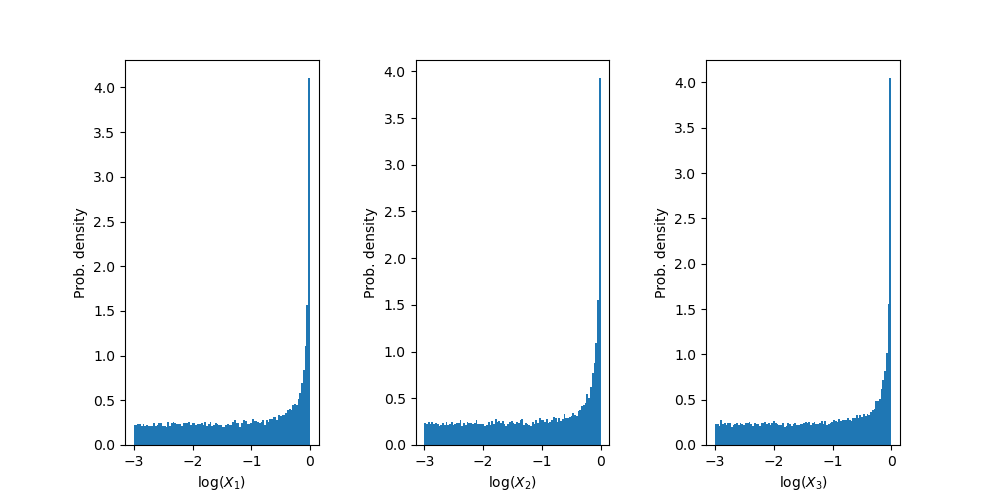

CPU times: user 6.01 s, sys: 13.1 ms, total: 6.02 s
Wall time: 6.01 s


In [8]:
%%time 

# centered log-ratio transform

x1_list = []
x2_list = []
x3_list = []


for i in range(50000):
    z2 = np.random.random_sample()
    z3 = np.random.random_sample()
    #z3 = np.random.random_sample()
    
    params = np.array([z2,z3])
    
    log10X_array = Dirchlet_Prior(params,3)
    
    if np.all(log10X_array != np.ones(3)*(-50.0)):
        x1_list.append(log10X_array[0])
        x2_list.append(log10X_array[1])
        x3_list.append(log10X_array[2])
    
    

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax[0].hist(x1_list,bins=100, density=True)
#ax[0].set_ylim((0,0.2))
ax[1].hist(x2_list,bins=100, density=True)
#ax[1].set_ylim((0,0.2))
ax[2].hist(x3_list,bins=100, density=True)
#ax[2].set_ylim((0,0.2))
ax[0].set_xlabel('log$(X_1)$')
ax[0].set_ylabel('Prob. density')
ax[1].set_xlabel('log$(X_2)$')
ax[1].set_ylabel('Prob. density')
ax[2].set_xlabel('log$(X_3)$')
ax[2].set_ylabel('Prob. density')
plt.subplots_adjust(wspace=0.5);

<IPython.core.display.Javascript object>


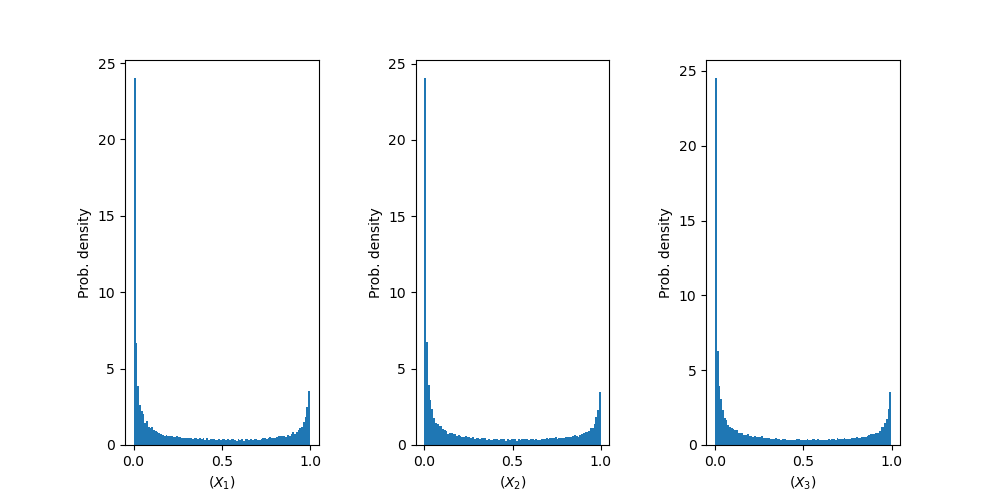

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax[0].hist(10**np.array(x1_list),bins=100, density=True)
#ax[0].set_ylim((0,0.2))
ax[1].hist(10**np.array(x2_list),bins=100, density=True)
#ax[1].set_ylim((0,0.2))
ax[2].hist(10**np.array(x3_list),bins=100, density=True)
#ax[2].set_ylim((0,0.2))
ax[0].set_xlabel('$(X_1)$')
ax[0].set_ylabel('Prob. density')
ax[1].set_xlabel('$(X_2)$')
ax[1].set_ylabel('Prob. density')
ax[2].set_xlabel('$(X_3)$')
ax[2].set_ylabel('Prob. density')
plt.subplots_adjust(wspace=0.5);

### 07.13.2020. Run a simple retrieval on simulated data to test if everything is working fine

Am. ice + cr ice model

Synthetic data parameters: 
1. Incidence angle $= 45.0$ deg., 
2. Emission angle $= 45.0$ deg., 
3. Phase angle $g = 90$ deg., 
4. Grain size of amorphous ice = $D_{am} = 200 \ \mu$m, 
5. Grain size of crystalline ice = $D_{cr} = 100 \ \mu$m,
6. number density fraction of amorphous ice $\textrm{f}_{am}= 0.5$, 
7. number density fraction of crystalline ice $\textrm{f}_{cr} = 1 - \textrm{f}_{am} = 0.5$, 
8. filling factor $\phi = 0.25$


Results:

1. No Gaussian noise + SNR=100 produces expected results. Parameters tightly constrained and well centered on the true parameter values.
2. No Gaussian noise + SNR=10 produces wider posteriors, and an especially wide posterior for $f_{am}$
3. Gaussian noise + SNR=100 produces expected results. Parameters are tightly constrained, although not perfectly centered at the true values
4. Gaussian noise + SNR=10 produces very unconstrained posteriors for log10$D_{cr}$ and $f_{cr}$. Quite different from the results I obtained when I performed the same retrieval (Case-3 of synthetic retrievals), but with 4096 points.
5. Repeat (4) with 4095 live points, instead of 512. Posteriors are same as 4, which is troubling as this result is different from the one I obtained during the JIRAM project (!!!).

### Found the error!

In the ``get_w_mix`` function, the grain size was hard-coded. So the same grain-size was being used for all the components. 

Now, its working perfectly fine and reproducing the synthetic retrieval results from the JIRAM paper. 

What about retrieval in the 1-2.5 microns range?

1. No Gaussian noise + SNR=10 produces unconstrained posteriors. $f_{am}$ and $\phi$ are especially unconstrained.
2. Gaussian noise + SNR=10 produces equally bad posteriors. 

I have a feeling that this is happening because in the 1-2.5 microns region, am. and cr. ice are basically indistinguishable. 
- It turns out that they are distinguishable, but in a mixture, due to crystalline ice's smaller grain size, its contribution to the average $\omega$ is quite low as compared to am. ice's contribution.  

/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:85: UserWarning: Lower wavelength value out of bounds with data. Data is in the 1.111136 - 22.227409 microns range.
  warnings.warn('Lower wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))
/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:85: UserWarning: Lower wavelength value out of bounds with data. Data is in the 1.111196 - 15.002941 microns range.
  warnings.warn('Lower wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))


<IPython.core.display.Javascript object>


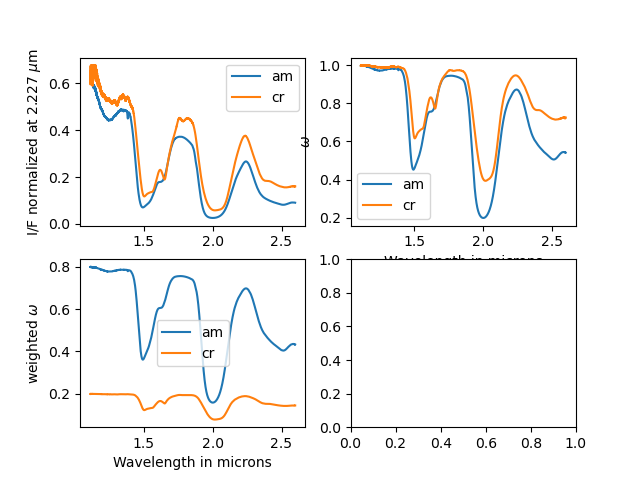

Text(0, 0.5, 'weighted $\\omega$')

In [3]:
# plot model spectra of am. ice and cr. ice only models in teh 1-2.5 microns reigon

# Define the fixed model parameters

mu_0 = np.cos(np.deg2rad(45.0))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(45.0))   # cosine of the emergence angle
g = 90    # phase angle 
B = 0     # No backscattering
s = 0     # internal diffuse scattering is zero
K = 1.0

start_wav = 0.9
end_wav = 2.6

n_am, k_am, wav_am = op_cons.get_mastrapa_nk(form='Amorphous',temperature=120, start_wav=start_wav,end_wav=end_wav)
n_cr, k_cr,wav_cr = op_cons.get_mastrapa_nk(form='Crystalline',temperature=120, start_wav=start_wav,end_wav=end_wav)

am_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,
           'comp':{'n':n_am,'k':k_am,'wav':wav_am,'log10D':2.3,'p_type':'HG2'}}
cr_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,
           'comp':{'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':2.0,'p_type':'HG2'}}

model_am, wav_model_am = rad_tran.one_comp(am_dict)
model_cr, wav_model_cr = rad_tran.one_comp(cr_dict)

fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(wav_model_am,model_am,label='am')
ax[0,0].plot(wav_model_cr,model_cr,label='cr')
ax[0,0].legend()
#ax[0].set_xlabel('Wavelength in microns')
ax[0,0].set_ylabel('I/F normalized at 2.227 $\mu$m')

w_am = rad_tran.get_w(n_am, k_am, wav_am, 200,s)
w_cr = rad_tran.get_w(n_cr, k_cr, wav_cr, 100, s)

ax[0,1].plot(wav_am,w_am,label='am')
ax[0,1].plot(wav_cr,w_cr,label='cr')
ax[0,1].legend()
ax[0,1].set_xlabel('Wavelength in microns')
ax[0,1].set_ylabel('$\omega$')

w_am_wt = (0.5*w_am*200**2)/(0.5*200**2 + 0.5*100**2)
w_cr_wt = (0.5*w_cr*100**2)/(0.5*200**2 + 0.5*100**2)

ax[1,0].plot(wav_am,w_am_wt,label='am')
ax[1,0].plot(wav_cr,w_cr_wt,label='cr')
ax[1,0].legend()
ax[1,0].set_xlabel('Wavelength in microns')
ax[1,0].set_ylabel('weighted $\omega$')

Try a few things:

1. Retrieval in the 1-2.5 microns range but now both ices have the same grain size
   - Broad posteriors

2. Retrieval in the 1-5 microns range but with different grain sizes
    - Perfect posteriors!
    
3. Retrieval in the 1-5 microns range but now both ices have the same grain size
    - Perfect posteriors!

In [9]:
# Define the fixed model parameters

mu_0 = np.cos(np.deg2rad(45.0))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(45.0))   # cosine of the emergence angle
g = 90    # phase angle 
B = 0     # No backscattering
s = 0     # internal diffuse scattering is zero

# Fix values of free parameters to generate the synthetic data

log10D_am_true = np.log10(100)    # log10(grain_size) of amorphous ice in microns
log10D_cr_true = np.log10(100)    # log10(grain_size) of crystalline ice in microns
f_am_true = 0.5    # number density fraction of amorphous ice
f_cr_true =  1 - f_am_true    # number density fraction of crystalline ice
phi_true = 0.25    # filling factor 
K_true = rad_tran.get_K(phi_true)    # porosity coefficient

# Water optical constants (at 120 K)

start_wav = 0.9
end_wav = 2.6
total_channels = 300

n_am, k_am, wav_am_old = op_cons.get_mastrapa_nk(form='Amorphous',temperature=120, start_wav=start_wav,end_wav=end_wav)
n_cr, k_cr,wav_cr_old = op_cons.get_mastrapa_nk(form='Crystalline',temperature=120, start_wav=start_wav,end_wav=end_wav)

# Modify the n spectra to remove values less than 1 (TEMPORARY FIX for the problem with equation for <D>)

idx = np.where(n_am < 1.0)[0]
n_am[idx] = 1.0

idx = np.where(n_cr < 1.0)[0]
n_cr[idx] = 1.0

# bin to low-resolution to speed up model calculation and retrieval

wav_new = np.linspace(wav_am_old.min(),wav_am_old.max(),num=total_channels)

final = bintools.binning(wav_am_old,n_am,newx=wav_new)
n_am, wav_am = final['bin_y'],final['bin_x']

final = bintools.binning(wav_am_old,k_am,newx=wav_new)
k_am, wav_am = final['bin_y'],final['bin_x']

final = bintools.binning(wav_cr_old,n_cr,newx=wav_new)
n_cr, wav_cr = final['bin_y'],final['bin_x']

final = bintools.binning(wav_cr_old,k_cr,newx=wav_new)
k_cr, wav_cr = final['bin_y'],final['bin_x']

/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:85: UserWarning: Lower wavelength value out of bounds with data. Data is in the 1.111136 - 22.227409 microns range.
  warnings.warn('Lower wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))
/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:85: UserWarning: Lower wavelength value out of bounds with data. Data is in the 1.111196 - 15.002941 microns range.
  warnings.warn('Lower wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))


<IPython.core.display.Javascript object>


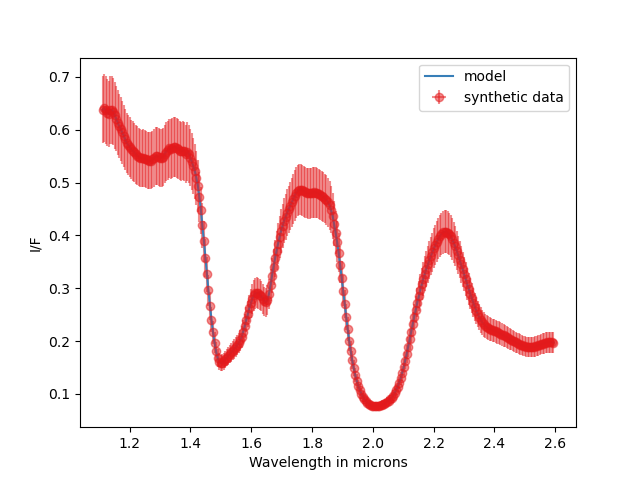

Text(0, 0.5, 'I/F')

In [10]:
# Create synthetic data

am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':f_am_true,'p_type':'HG2'}
cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':f_cr_true,'p_type':'HG2'}

param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K_true,'s':s,'comp_dict_list':[am_dict, cr_dict]}

data_syn, wav_syn = rad_tran.multi_comp_IM(param_dict)

# normalize the data

#idx = utils.find_nearest(array=wav_syn,value=2.227)
#norm_factor = data_syn[idx]

#data_syn = data_syn/norm_factor

wav_model_orig, model_orig = np.copy(wav_syn), np.copy(data_syn)

# calculate noise

snr = 10

noise_syn = data_syn/snr

# add scatter to data

#np.random.seed(42)
#data_syn = data_syn + noise_syn*np.random.randn(data_syn.size)

fig, ax = plt.subplots()

ax.errorbar(wav_syn, data_syn,yerr=noise_syn, xerr=0,marker='o',color='#e41a1c',ls='none', 
            alpha=0.5, label='synthetic data')
ax.plot(wav_model_orig,model_orig,label='model',color='#377eb8')
ax.legend()
ax.set_xlabel('Wavelength in microns')
ax.set_ylabel('I/F')

In [11]:
# Perform Bayesian retrieval using a multi component model

# set bounds for priors on free-parameters: log10D_am, log10D_cr, f_am and phi

bounds = [(1,3),(1,3),(0,1),(0.01,0.52)]


def prior_trans_2comp(theta,prior_bounds=bounds):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)
    
    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.
        
    Returns
    -------
    
    tuple containing all the transformed free parameter values
    """
    
    transformed = ()
    
    for i,param_prime in enumerate(theta):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]
        
        param = param_prime*(param_max - param_min) + param_min
        
        transformed += (param,)
        
    return transformed

def loglik_2comp(theta):
    """
    The log-likelihood function.
    """

    log10D_am, log10D_cr,f_am, phi = theta # unpack the parameters
    
    f_cr = 1 - f_am
    
    K = rad_tran.get_K(phi)
    
    # the fixed parameters are global and have been defined earlier in the notebook

    am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am, 'f':f_am,'p_type':'HG2'}
    cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr, 'f':f_cr,'p_type':'HG2'}

    param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp_dict_list':[am_dict, cr_dict]}
    
    model, wav_model = rad_tran.multi_comp_IM(param_dict)
    
    # normalize the model
    #idx = utils.find_nearest(array=wav_model,value=2.227)
    #model = model/model[idx]
    
    # check that noise is an array (to evaluate norm_log correctly)
    
    if not(isinstance(noise_syn, np.ndarray)):
        raise TypeError('noise variable should be a numpy array') 
    
    norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise_syn)**2))
    
    chisq = -0.5*np.sum((model-data_syn)**2/(noise_syn)**2)

    return chisq + norm_log

In [12]:
nlive = 512       # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 4         # four parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler = NestedSampler(loglik_2comp, prior_trans_2comp, ndims,
                        bound=bound, sample=sample, nlive=nlive,pool=pool, queue_size=Nproc)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=True)
t1 = time()

timedynesty = (t1-t0)

hours,minutes,seconds = utils.get_hms(timedynesty)

print("Time taken to run 'dynesty' (multiprocessing) is {} hours {} minutes {} seconds".format(hours,minutes,seconds))

iter: 6338 | +512 | bound: 21 | nc: 1 | ncall: 33952 | eff(%): 20.176 | loglstar:   -inf < 783.242 <    inf | logz: 773.210 +/-  0.184 | dlogz:  0.000 >  0.100                                       

Time taken to run 'dynesty' (multiprocessing) is 0.0 hours 4.0 minutes 45.82777380943298 seconds


<IPython.core.display.Javascript object>


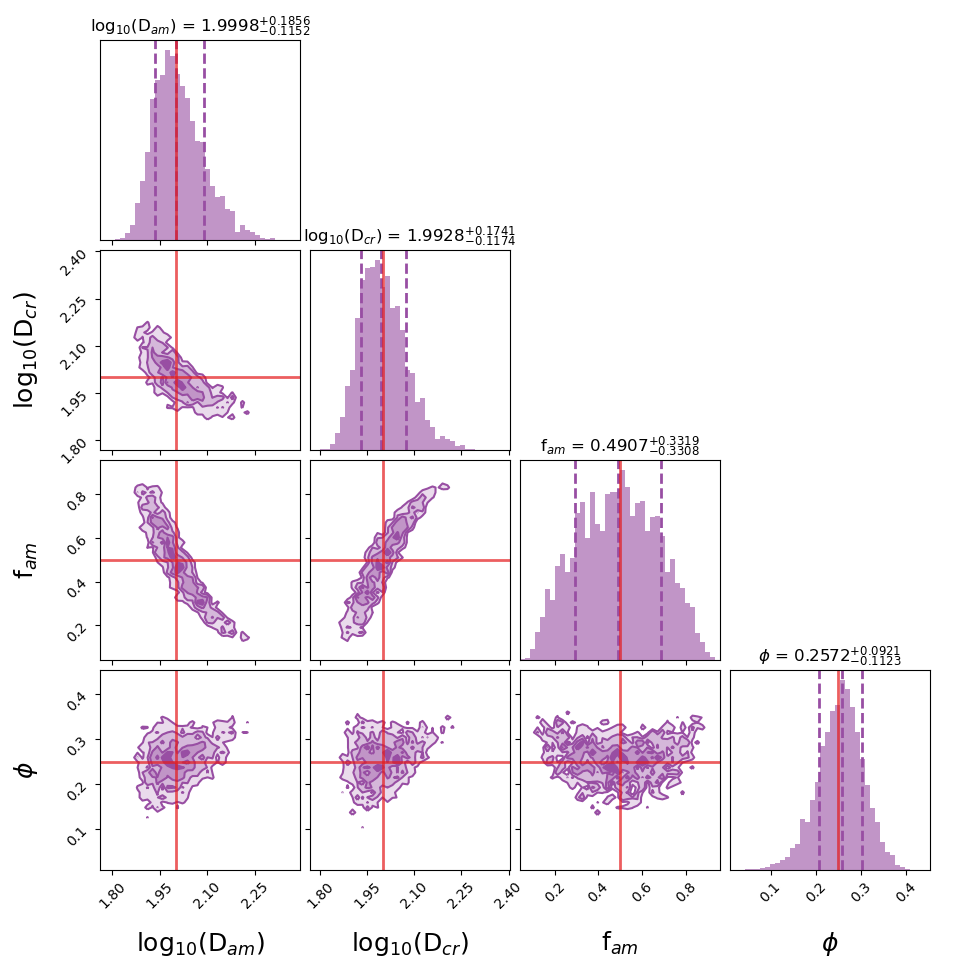

In [13]:
# plot posteriors

labels=['log$_{10}$(D$_{am}$)','log$_{10}$(D$_{cr}$)', 'f$_{am}$','$\phi$']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

fig, axes = dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                              title_fmt='.4f',truths=[log10D_am_true,log10D_cr_true,f_am_true,phi_true],truth_color='#e41a1c',
                              label_kwargs={'fontsize':label_font}, hist2d_kwargs={'plot_contours':True,'fill_contours':True})

#### Posterior plot for analysis of full range data: 1-5 $\mu$m

<IPython.core.display.Javascript object>


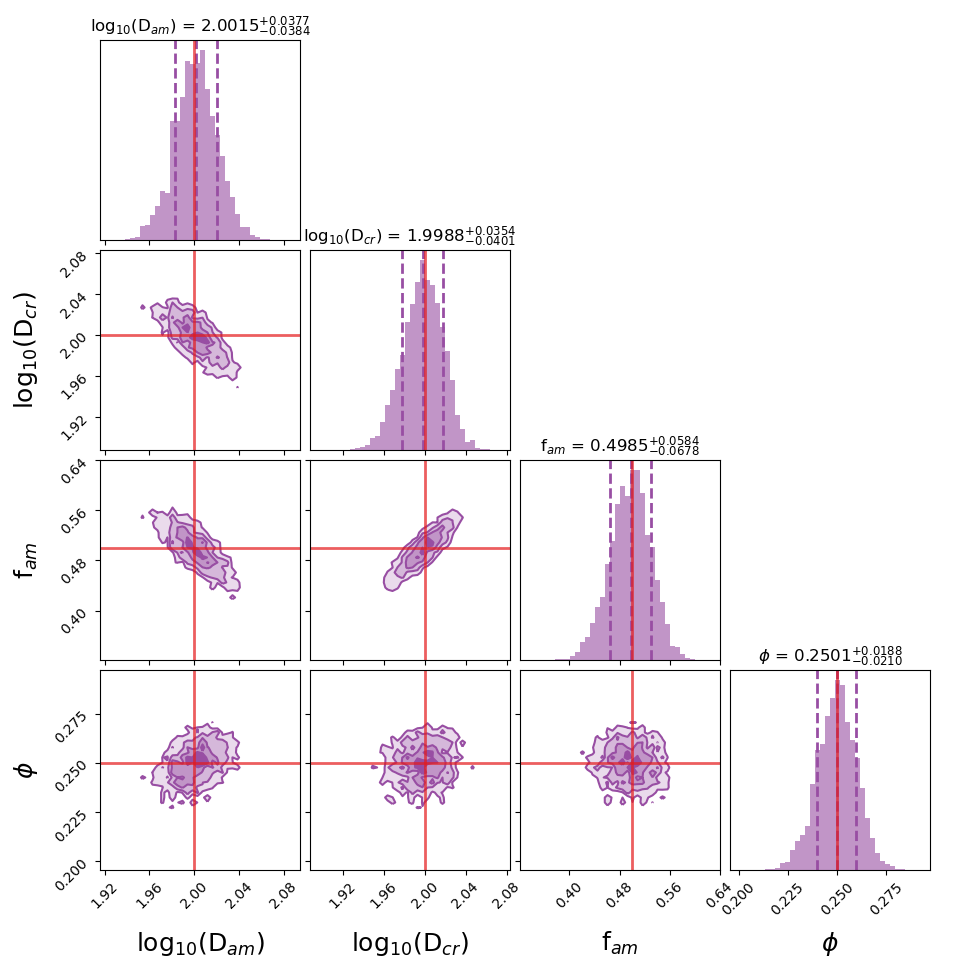

## Experiment with three-component retrieval. 

Am. ice + cr. ice + SAO model

### Experiment 1: Retrieval with abundances as the only free parameters. Well constrained posteriors for uniform prior, log-uniform prior and dirichlet prior cases. 

In [2]:
# Define the fixed model parameters

mu_0 = np.cos(np.deg2rad(45.0))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(45.0))   # cosine of the emergence angle
g = 90    # phase angle 
B = 0     # No backscattering
s = 0     # internal diffuse scattering is zero

# Fix values of free parameters to generate the synthetic data

log10D_am_true = np.log10(100)    # log10(grain_size) of amorphous ice in microns
log10D_cr_true = np.log10(100)    # log10(grain_size) of crystalline ice in microns
log10D_sao_true = np.log10(100)    # log10(grain_size) of crystalline ice in microns
f_am_true = 0.33    # number density fraction of amorphous ice
f_cr_true =  0.33    # number density fraction of crystalline ice
f_sao_true = 1 -f_am_true - f_cr_true
phi_true = 0.25    # filling factor 
K_true = rad_tran.get_K(phi_true)    # porosity coefficient

# Water optical constants (at 120 K)

start_wav = 0.9
end_wav = 2.6
total_channels = 250

n_am, k_am, wav_am = op_cons.get_mastrapa_nk(form='Amorphous',temperature=120, start_wav=start_wav,end_wav=end_wav)
n_cr, k_cr,wav_cr = op_cons.get_mastrapa_nk(form='Crystalline',temperature=120, start_wav=start_wav,end_wav=end_wav)
n_sao, k_sao, wav_sao = op_cons.get_carlson_nk(0.9,2.6)

wav_list = [wav_am,wav_cr, wav_sao]
k_list = [k_am,k_cr, k_sao]
n_list = [n_am,n_cr, n_sao]

k_list, wav_common = pyhapke.utils.spectra_list_match(k_list,wav_list)
n_list, junk = pyhapke.utils.spectra_list_match(n_list,wav_list)

n_am, k_am, wav_am = n_list[0], k_list[0], wav_common
n_cr, k_cr,wav_cr = n_list[1], k_list[1], wav_common
n_sao, k_sao, wav_sao = n_list[2], k_list[2], wav_common

/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:85: UserWarning: Lower wavelength value out of bounds with data. Data is in the 1.111136 - 22.227409 microns range.
  warnings.warn('Lower wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))
/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:85: UserWarning: Lower wavelength value out of bounds with data. Data is in the 1.111196 - 15.002941 microns range.
  warnings.warn('Lower wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))
/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:265: UserWarning: Upper wavelength value out of bounds with data. Data is in the 0.899000 - 2.500000 microns range.
  warnings.warn('Upper wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))


<IPython.core.display.Javascript object>


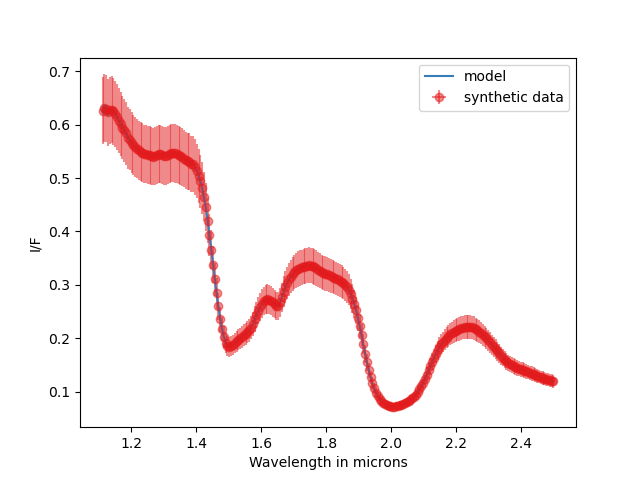

Text(0, 0.5, 'I/F')

In [3]:
# Create synthetic data

am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':f_am_true,'p_type':'HG2'}
cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':f_cr_true,'p_type':'HG2'}
sao_dict = {'n':n_sao,'k':k_sao,'wav':wav_sao,'log10D':log10D_sao_true, 'f':f_sao_true,'p_type':'HG2'}

param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K_true,'s':s,'comp_dict_list':[am_dict, cr_dict, sao_dict]}

data_syn, wav_syn = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

wav_model_orig,model_orig = np.copy(wav_syn), np.copy(data_syn)

# reduce resolution of data

wav_new = np.linspace(wav_am.min(),wav_am.max(),num=250)

final = bintools.binning(wav_syn,data_syn,newx=wav_new)
data_syn, wav_syn = final['bin_y'],final['bin_x']

# calculate noise

snr = 10

noise_syn = data_syn/snr

# add scatter to data

#np.random.seed(42)
#data_syn = data_syn + noise_syn*np.random.randn(data_syn.size)

fig, ax = plt.subplots()

ax.errorbar(wav_syn, data_syn,yerr=noise_syn, xerr=0,marker='o',color='#e41a1c',ls='none', 
            alpha=0.5, label='synthetic data')
ax.plot(wav_model_orig,model_orig,label='model',color='#377eb8')
ax.legend()
ax.set_xlabel('Wavelength in microns')
ax.set_ylabel('I/F')

#### Three component retrieval with uniform prior on abundances, and $f_{sao} = 1 - f_{am} - f_{cr}$. 
#### Two free parameters: $f_{am}$ and $f_{sao}$

In [4]:
# Perform Bayesian retrieval using a multi component model

# set bounds for priors on free-parameters: f_am, f_cr

bounds = [(0,1),(0,1)]


def prior_trans_2comp(theta,prior_bounds=bounds):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)
    
    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.
        
    Returns
    -------
    
    tuple containing all the transformed free parameter values
    """
    
    transformed = ()
    
    for i,param_prime in enumerate(theta):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]
        
        param = param_prime*(param_max - param_min) + param_min
        
        transformed += (param,)
        
    return transformed

def loglik_2comp(theta):
    """
    The log-likelihood function.
    """

    f_am, f_cr = theta # unpack the parameters
    
    if (f_am + f_cr) < 1:
    
        f_sao = 1 - f_am - f_cr
    
        # the fixed parameters are global and have been defined earlier in the notebook

        am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':f_am,'p_type':'HG2'}
        cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':f_cr,'p_type':'HG2'}
        sao_dict = {'n':n_sao,'k':k_sao,'wav':wav_sao,'log10D':log10D_sao_true, 'f':f_sao,'p_type':'HG2'}

        param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K_true,'s':s,'comp_dict_list':[am_dict, cr_dict, sao_dict]}

        model, wav_model = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

        # reduce model to data's resolution
        
        final = bintools.binning(wav_model,model,newx=wav_syn)
        model, wav_model = final['bin_y'],final['bin_x']
        
        # check that noise is an array (to evaluate norm_log correctly)

        if not(isinstance(noise_syn, np.ndarray)):
            raise TypeError('noise variable should be a numpy array') 

        norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise_syn)**2))

        chisq = -0.5*np.sum((model-data_syn)**2/(noise_syn)**2)

        return chisq + norm_log
    
    else:
        return -100.

In [5]:
nlive = 512       # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2         # four parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler = NestedSampler(loglik_2comp, prior_trans_2comp, ndims,
                        bound=bound, sample=sample, nlive=nlive,pool=pool, queue_size=Nproc)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=True)
t1 = time()

timedynesty = (t1-t0)

hours,minutes,seconds = utils.get_hms(timedynesty)

print("Time taken to run 'dynesty' (multiprocessing) is {} hours {} minutes {} seconds".format(hours,minutes,seconds))

iter: 4522 | +512 | bound: 7 | nc: 1 | ncall: 26105 | eff(%): 19.284 | loglstar:   -inf < 701.075 <    inf | logz: 694.601 +/-  0.146 | dlogz:  0.000 >  0.100                                        

Time taken to run 'dynesty' (multiprocessing) is 0.0 hours 1.0 minutes 17.225058555603027 seconds


Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Process ForkPoolWorker-14:
Process ForkPoolWorker-8:
Process ForkPoolWorker-11:
Process ForkPoolWorker-13:
Process ForkPoolWorker-7:
Process ForkPoolWorker-19:
Process ForkPoolWorker-3:
Process ForkPoolWorker-17:
Process ForkPoolWorker-20:
Process ForkPoolWorker-15:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-18:
Process ForkPoolWorker-12:
Process ForkPoolWorker-16:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiproc

  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/li

<IPython.core.display.Javascript object>


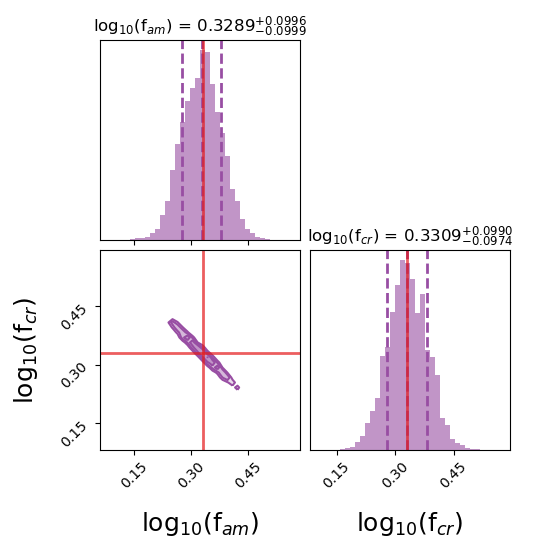

(<Figure size 550x550 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f368c289210>,
       dtype=object))

In [6]:
# plot posteriors

labels=['log$_{10}$(f$_{am}$)','log$_{10}$(f$_{cr}$)']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                              title_fmt='.4f',truths=[f_am_true,f_cr_true],truth_color='#e41a1c',
                              label_kwargs={'fontsize':label_font}, hist2d_kwargs={'plot_contours':True,'fill_contours':True})

<IPython.core.display.Javascript object>


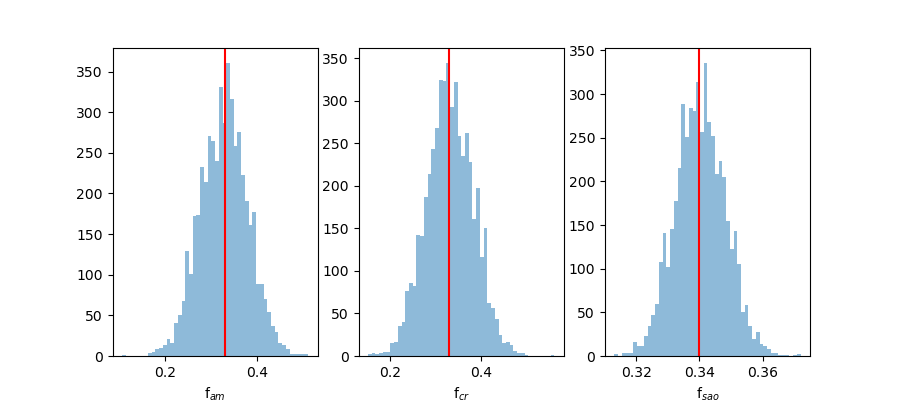

In [8]:
# plot all posterior for all abundances

# draw posterior samples
weights = np.exp(sampler.results['logwt'] - sampler.results['logz'][-1])
samples_mod = resample_equal(sampler.results['samples'], weights)

# draw properly weighted posterior samples

weights = np.exp(sampler.results['logwt'] - sampler.results['logz'][-1])
samples_mod = resample_equal(sampler.results['samples'], weights)

f_am_list, f_cr_list, f_sao_list = [], [], []

for i in range(samples_mod.shape[0]):
    f_am = samples_mod[i,0]
    f_cr = samples_mod[i,1]
    f_sao = 1 - f_am - f_cr
    f_am_list.append(f_am)
    f_cr_list.append(f_cr)
    f_sao_list.append(f_sao)
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))

ax[0].hist(f_am_list, alpha=0.5, bins=50)
ax[0].set_xlabel('f$_{am}$')
ax[0].axvline(x=f_am_true, c='r')

ax[1].hist(f_cr_list, alpha=0.5, bins=50)
ax[1].set_xlabel('f$_{cr}$')
ax[1].axvline(x=(f_cr_true), c='r')

ax[2].hist(f_sao_list, alpha=0.5, bins=50)
ax[2].set_xlabel('f$_{sao}$')
ax[2].axvline(x=(f_sao_true), c='r')

#### Three component retrieval with Jeffery's prior on abundances, and $f_{sao} = 1 - f_{am} - f_{cr}$. 
#### Two free parameters: $f_{am}$ and $f_{cr}$

In [9]:
# Perform Bayesian retrieval using a multi component model

# set bounds for priors on free-parameters: log10f_am, log10f_cr

bounds = [(-3,0),(-3,0)]


def prior_trans_2comp(theta,prior_bounds=bounds):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)
    
    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.
        
    Returns
    -------
    
    tuple containing all the transformed free parameter values
    """
    
    transformed = ()
    
    for i,param_prime in enumerate(theta):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]
        
        param = param_prime*(param_max - param_min) + param_min
        
        transformed += (param,)
        
    return transformed

def loglik_2comp(theta):
    """
    The log-likelihood function.
    """

    log10f_am, log10f_cr = theta # unpack the parameters
    
    if (10**log10f_am + 10**log10f_cr) < 1:
    
        f_sao = 1 - 10**log10f_am - 10**log10f_cr
    
        # the fixed parameters are global and have been defined earlier in the notebook

        am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':10**log10f_am,'p_type':'HG2'}
        cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':10**log10f_cr,'p_type':'HG2'}
        sao_dict = {'n':n_sao,'k':k_sao,'wav':wav_sao,'log10D':log10D_sao_true, 'f':f_sao,'p_type':'HG2'}

        param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K_true,'s':s,'comp_dict_list':[am_dict, cr_dict, sao_dict]}

        model, wav_model = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

        # reduce model to data's resolution
        
        final = bintools.binning(wav_model,model,newx=wav_syn)
        model, wav_model = final['bin_y'],final['bin_x']
        
        # check that noise is an array (to evaluate norm_log correctly)

        if not(isinstance(noise_syn, np.ndarray)):
            raise TypeError('noise variable should be a numpy array') 

        norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise_syn)**2))

        chisq = -0.5*np.sum((model-data_syn)**2/(noise_syn)**2)

        return chisq + norm_log
    
    else:
        return -100.

In [10]:
nlive = 512       # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2         # four parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler = NestedSampler(loglik_2comp, prior_trans_2comp, ndims,
                        bound=bound, sample=sample, nlive=nlive,pool=pool, queue_size=Nproc)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=True)
t1 = time()

timedynesty = (t1-t0)

hours,minutes,seconds = utils.get_hms(timedynesty)

print("Time taken to run 'dynesty' (multiprocessing) is {} hours {} minutes {} seconds".format(hours,minutes,seconds))

iter: 5100 | +512 | bound: 15 | nc: 1 | ncall: 29682 | eff(%): 18.907 | loglstar:   -inf < 701.075 <    inf | logz: 693.472 +/-  0.161 | dlogz:  0.000 >  0.100                                       

Time taken to run 'dynesty' (multiprocessing) is 0.0 hours 1.0 minutes 43.239893198013306 seconds


Process ForkPoolWorker-31:
Process ForkPoolWorker-26:
Process ForkPoolWorker-35:
Process ForkPoolWorker-32:
Process ForkPoolWorker-21:
Process ForkPoolWorker-37:
Process ForkPoolWorker-36:
Process ForkPoolWorker-34:
Process ForkPoolWorker-38:
Process ForkPoolWorker-33:
Process ForkPoolWorker-28:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-27:
Traceback (most recent call last):
Process ForkPoolWorker-39:
Traceback (most recent call last):
Process ForkPoolWorker-40:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Proce

  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/qu

<IPython.core.display.Javascript object>


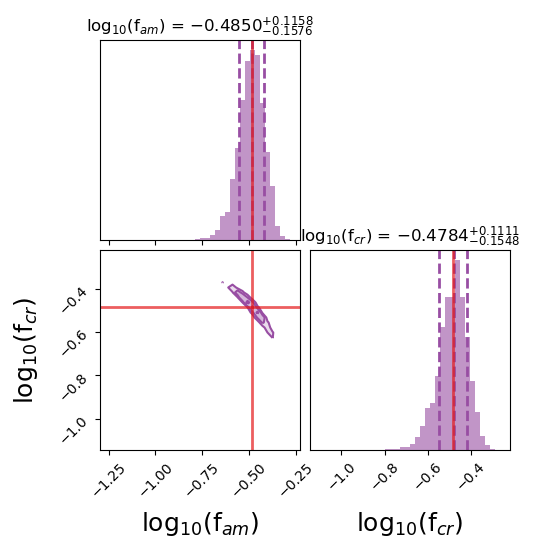

(<Figure size 550x550 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36ea322f50>,
       dtype=object))

In [11]:
# plot posteriors

labels=['log$_{10}$(f$_{am}$)','log$_{10}$(f$_{cr}$)']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                              title_fmt='.4f',truths=[np.log10(f_am_true),np.log10(f_cr_true)],truth_color='#e41a1c',
                              label_kwargs={'fontsize':label_font}, hist2d_kwargs={'plot_contours':True,'fill_contours':True})

<IPython.core.display.Javascript object>


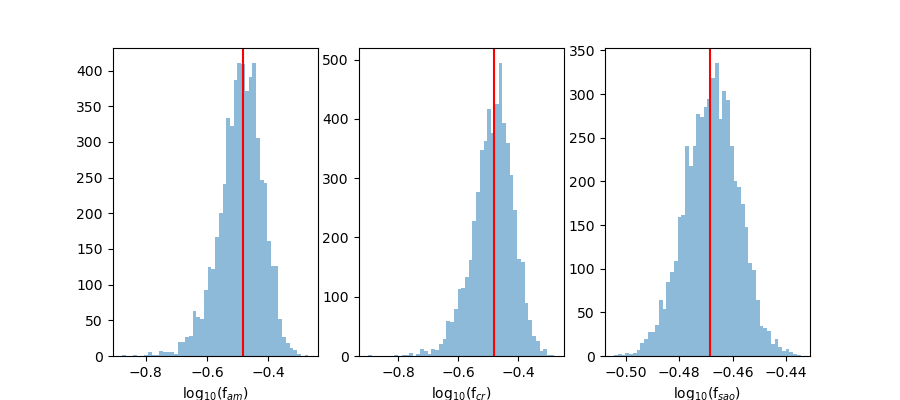

In [12]:
# plot all posterior for all abundances

# draw properly weighted posterior samples

weights = np.exp(sampler.results['logwt'] - sampler.results['logz'][-1])
samples_mod = resample_equal(sampler.results['samples'], weights)

log10f_am_list, log10f_cr_list, log10f_sao_list = [], [], []

for i in range(samples_mod.shape[0]):
    log10f_am = samples_mod[i,0]
    log10f_cr = samples_mod[i,1]
    log10f_sao = np.log10(1 - 10**log10f_am - 10**log10f_cr)
    log10f_am_list.append(log10f_am)
    log10f_cr_list.append(log10f_cr)
    log10f_sao_list.append(log10f_sao)
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))

ax[0].hist(log10f_am_list, alpha=0.5, bins=50)
ax[0].set_xlabel('log$_{10}$(f$_{am}$)')
ax[0].axvline(x=np.log10(f_am_true), c='r')

ax[1].hist(log10f_cr_list, alpha=0.5, bins=50)
ax[1].set_xlabel('log$_{10}$(f$_{cr}$)')
ax[1].axvline(x=np.log10(f_cr_true), c='r')

ax[2].hist(log10f_sao_list, alpha=0.5, bins=50)
ax[2].set_xlabel('log$_{10}$(f$_{sao}$)')
ax[2].axvline(x=np.log10(f_sao_true), c='r')

#### Re-run the same retrieval but now with Dirichlet prior

In [13]:
# Perform Bayesian retrieval using a multi component model

# set bounds for priors on free-parameters: log10f_am, log10f_cr

lower_bound = -3.0
n_species = 3

def Dirichlet_Prior(params, lower_bound=lower_bound, n_species=n_species):
    
    ''' Impliments a Dirchlet prior for chemical mixing ratios.
    
        Dir[i] here is the centred log-ratio transform of the mixing ratio, X[i]
       
    '''
    
    n = n_species   # Number of species free parameters
    limit = lower_bound           # Lowest (log) mixing ratio considered

    # Limits correspond to condition that all X_i > 10^(limit)
    prior_lower_Dir = ((n-1.0)/n) * (limit * np.log(10.0) + np.log(n-1.0))      # Lower limit corresponds to species underabundant
    prior_upper_Dir = ((1.0-n)/n) * (limit * np.log(10.0))                      # Upper limit corresponds to species dominant

    Dir = np.zeros(shape=(n))   # Vector of log ratio parameters
    X = np.zeros(shape=(n))     # Vector of mixing ratio parameters
    
    # Evalaute centred log-ratio parameters by uniformly sampling between limits
    for i in range(n-1):
 
        Dir[1+i] = ((params[i] * (prior_upper_Dir - prior_lower_Dir)) + prior_lower_Dir) 
          
    if (np.abs(np.sum(Dir[1:n])) <= prior_upper_Dir):   # Impose same prior on X_0
    #if 1==1:
            
        Dir[0] = -1.0*np.sum(Dir[1:n])   # Dir_n (corresponding to mixing ratio of first species) must equal 0, so that X_i sum to 1
        
        if ((np.max(Dir) - np.min(Dir)) <= (-1.0 * limit * np.log(10.0))):      # Necessary for all X_i > 10^(limit)    
        #if 1==1:
            
            normalisation = np.sum(np.exp(Dir))
        
            for i in range(n):
                
                # Map log-ratio parameters to mixing ratios
                X[i] = np.exp(Dir[i]) / normalisation   # Vector of mixing ratios (should sum to 1!)
                
                # One final check that all X_i > 10^(limit)
                if (X[i] < 10**limit): return (np.ones(n)*(-50.0))    # Fails check -> return dummy array of log values
            
            return np.log10(X)   # Return vector of log-mixing ratios
        
        elif ((np.max(Dir) - np.min(Dir)) > (-1.0 * limit * np.log(10.0))):
        
            return (np.ones(n)*(-50.0))   # Fails check -> return dummy array of log values
    
    elif (np.abs(np.sum(Dir[1:n])) > prior_upper_Dir):   # If falls outside of allowed triangular subspace
        
        return (np.ones(n)*(-50.0))    # Fails check -> return dummy array of log values



def loglik_2comp(theta):
    """
    The log-likelihood function.
    """
    if np.all(theta != np.ones(3)*(-50.0)):
        log10f_sao, log10f_am, log10f_cr = theta[0], theta[1], theta[2] # unpack the parameters

        # the fixed parameters are global and have been defined earlier in the notebook

        am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':10**log10f_am,'p_type':'HG2'}
        cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':10**log10f_cr,'p_type':'HG2'}
        sao_dict = {'n':n_sao,'k':k_sao,'wav':wav_sao,'log10D':log10D_sao_true, 'f':10**log10f_sao,'p_type':'HG2'}

        param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K_true,'s':s,'comp_dict_list':[am_dict, cr_dict, sao_dict]}

        model, wav_model = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

        # reduce model to data's resolution

        final = bintools.binning(wav_model,model,newx=wav_syn)
        model, wav_model = final['bin_y'],final['bin_x']

        # check that noise is an array (to evaluate norm_log correctly)

        if not(isinstance(noise_syn, np.ndarray)):
            raise TypeError('noise variable should be a numpy array') 

        norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise_syn)**2))

        chisq = -0.5*np.sum((model-data_syn)**2/(noise_syn)**2)

        return chisq + norm_log
    
    else:
        return -100.

In [14]:
nlive = 512       # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2         # two parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler = NestedSampler(loglik_2comp, Dirichlet_Prior, ndims,
                        bound=bound, sample=sample, nlive=nlive,pool=pool, queue_size=Nproc)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=True)
t1 = time()

timedynesty = (t1-t0)

hours,minutes,seconds = utils.get_hms(timedynesty)

print("Time taken to run 'dynesty' (multiprocessing) is {} hours {} minutes {} seconds".format(hours,minutes,seconds))

iter: 5806 | +512 | bound: 12 | nc: 1 | ncall: 33985 | eff(%): 18.591 | loglstar:   -inf < 701.075 <    inf | logz: 692.095 +/-  0.177 | dlogz:  0.000 >  0.100                                       

Time taken to run 'dynesty' (multiprocessing) is 0.0 hours 1.0 minutes 46.953957319259644 seconds


Process ForkPoolWorker-48:
Process ForkPoolWorker-55:
Process ForkPoolWorker-43:
Process ForkPoolWorker-42:
Process ForkPoolWorker-58:
Process ForkPoolWorker-41:
Process ForkPoolWorker-57:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-53:
Process ForkPoolWorker-56:
Process ForkPoolWorker-54:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-49:
Process ForkPoolWorker-60:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-44:
Process ForkPoolWorker-51:
Process ForkPoolWorker-45:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-52:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last)

  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/pool.py", line 110, in work

<IPython.core.display.Javascript object>


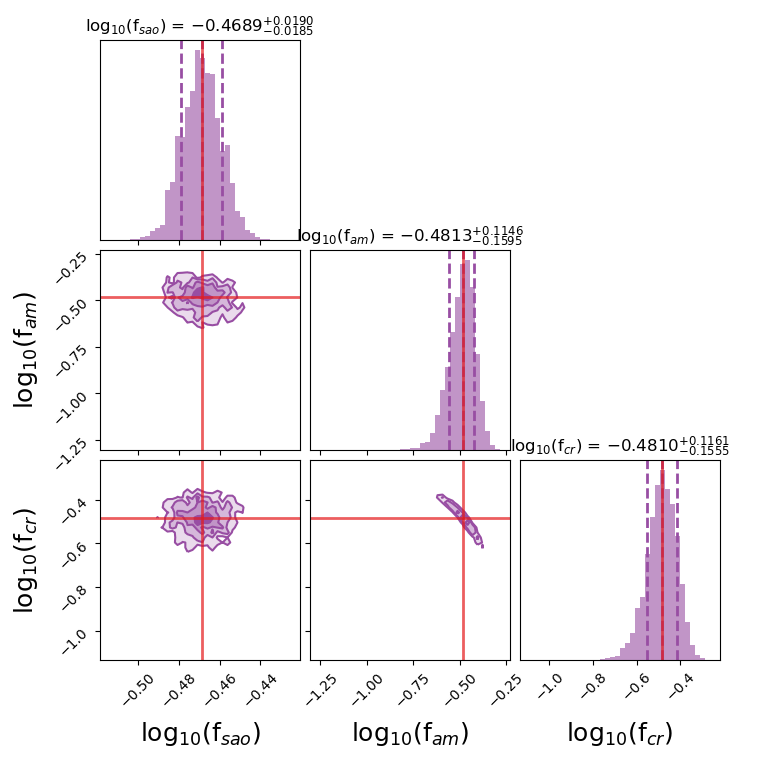

(<Figure size 760x760 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36e04fa090>,
       dtype=object))

In [15]:
# plot posteriors

labels=['log$_{10}$(f$_{sao}$)','log$_{10}$(f$_{am}$)','log$_{10}$(f$_{cr}$)']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                              title_fmt='.4f',truths=[np.log10(f_sao_true),np.log10(f_am_true),np.log10(f_cr_true)],truth_color='#e41a1c',
                              label_kwargs={'fontsize':label_font}, hist2d_kwargs={'plot_contours':True,'fill_contours':True})

### Experiment 2: Abundances + $\phi$ are free parameters

In [2]:
# Define the fixed model parameters

mu_0 = np.cos(np.deg2rad(45.0))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(45.0))   # cosine of the emergence angle
g = 90    # phase angle 
B = 0     # No backscattering
s = 0     # internal diffuse scattering is zero

# Fix values of free parameters to generate the synthetic data

log10D_am_true = np.log10(100)    # log10(grain_size) of amorphous ice in microns
log10D_cr_true = np.log10(100)    # log10(grain_size) of crystalline ice in microns
log10D_sao_true = np.log10(100)    # log10(grain_size) of crystalline ice in microns
f_am_true = 0.33    # number density fraction of amorphous ice
f_cr_true =  0.33    # number density fraction of crystalline ice
f_sao_true = 1 -f_am_true - f_cr_true
phi_true = 0.25    # filling factor 
K_true = rad_tran.get_K(phi_true)    # porosity coefficient

# Water optical constants (at 120 K)

start_wav = 0.9
end_wav = 2.6
total_channels = 250

n_am, k_am, wav_am = op_cons.get_mastrapa_nk(form='Amorphous',temperature=120, start_wav=start_wav,end_wav=end_wav)
n_cr, k_cr,wav_cr = op_cons.get_mastrapa_nk(form='Crystalline',temperature=120, start_wav=start_wav,end_wav=end_wav)
n_sao, k_sao, wav_sao = op_cons.get_carlson_nk(0.9,2.6)

wav_list = [wav_am,wav_cr, wav_sao]
k_list = [k_am,k_cr, k_sao]
n_list = [n_am,n_cr, n_sao]

k_list, wav_common = pyhapke.utils.spectra_list_match(k_list,wav_list)
n_list, junk = pyhapke.utils.spectra_list_match(n_list,wav_list)

n_am, k_am, wav_am = n_list[0], k_list[0], wav_common
n_cr, k_cr,wav_cr = n_list[1], k_list[1], wav_common
n_sao, k_sao, wav_sao = n_list[2], k_list[2], wav_common

/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:85: UserWarning: Lower wavelength value out of bounds with data. Data is in the 1.111136 - 22.227409 microns range.
  warnings.warn('Lower wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))
/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:85: UserWarning: Lower wavelength value out of bounds with data. Data is in the 1.111196 - 15.002941 microns range.
  warnings.warn('Lower wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))
/data1/ishanm/Research/Dev/PyHapke/pyhapke/op_cons.py:265: UserWarning: Upper wavelength value out of bounds with data. Data is in the 0.899000 - 2.500000 microns range.
  warnings.warn('Upper wavelength value out of bounds with data. Data is in the %f - %f microns range.'%(wav.min(), wav.max()))


<IPython.core.display.Javascript object>


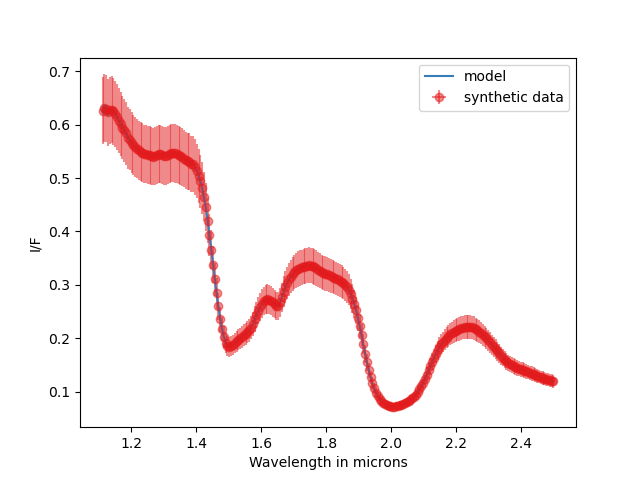

Text(0, 0.5, 'I/F')

In [3]:
# Create synthetic data

am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':f_am_true,'p_type':'HG2'}
cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':f_cr_true,'p_type':'HG2'}
sao_dict = {'n':n_sao,'k':k_sao,'wav':wav_sao,'log10D':log10D_sao_true, 'f':f_sao_true,'p_type':'HG2'}

param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K_true,'s':s,'comp_dict_list':[am_dict, cr_dict, sao_dict]}

data_syn, wav_syn = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

wav_model_orig,model_orig = np.copy(wav_syn), np.copy(data_syn)

# reduce resolution of data

wav_new = np.linspace(wav_am.min(),wav_am.max(),num=250)

final = bintools.binning(wav_syn,data_syn,newx=wav_new)
data_syn, wav_syn = final['bin_y'],final['bin_x']

# calculate noise

snr = 10

noise_syn = data_syn/snr

# add scatter to data

#np.random.seed(42)
#data_syn = data_syn + noise_syn*np.random.randn(data_syn.size)

fig, ax = plt.subplots()

ax.errorbar(wav_syn, data_syn,yerr=noise_syn, xerr=0,marker='o',color='#e41a1c',ls='none', 
            alpha=0.5, label='synthetic data')
ax.plot(wav_model_orig,model_orig,label='model',color='#377eb8')
ax.legend()
ax.set_xlabel('Wavelength in microns')
ax.set_ylabel('I/F')

#### Three component retrieval with uniform prior on abundances, and $f_{sao} = 1 - f_{am} - f_{cr}$. 
#### Three free parameters: $f_{am}$, $f_{cr}$ ,  and $\phi$

In [18]:
# Perform Bayesian retrieval using a multi component model

# set bounds for priors on free-parameters: f_am, f_cr

bounds = [(0,1),(0,1),(0.01,0.52)]


def prior_trans_2comp(theta,prior_bounds=bounds):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)
    
    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.
        
    Returns
    -------
    
    tuple containing all the transformed free parameter values
    """
    
    transformed = ()
    
    for i,param_prime in enumerate(theta):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]
        
        param = param_prime*(param_max - param_min) + param_min
        
        transformed += (param,)
        
    return transformed

def loglik_2comp(theta):
    """
    The log-likelihood function.
    """

    f_am, f_cr, phi = theta # unpack the parameters
    
    if (f_am + f_cr) < 1:
    
        f_sao = 1 - f_am - f_cr
        
        K = rad_tran.get_K(phi)
    
        # the fixed parameters are global and have been defined earlier in the notebook

        am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':f_am,'p_type':'HG2'}
        cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':f_cr,'p_type':'HG2'}
        sao_dict = {'n':n_sao,'k':k_sao,'wav':wav_sao,'log10D':log10D_sao_true, 'f':f_sao,'p_type':'HG2'}

        param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp_dict_list':[am_dict, cr_dict, sao_dict]}

        model, wav_model = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

        # reduce model to data's resolution
        
        final = bintools.binning(wav_model,model,newx=wav_syn)
        model, wav_model = final['bin_y'],final['bin_x']
        
        # check that noise is an array (to evaluate norm_log correctly)

        if not(isinstance(noise_syn, np.ndarray)):
            raise TypeError('noise variable should be a numpy array') 

        norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise_syn)**2))

        chisq = -0.5*np.sum((model-data_syn)**2/(noise_syn)**2)

        return chisq + norm_log
    
    else:
        return -100.

In [19]:
nlive = 512       # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3         # four parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler = NestedSampler(loglik_2comp, prior_trans_2comp, ndims,
                        bound=bound, sample=sample, nlive=nlive,pool=pool, queue_size=Nproc)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=True)
t1 = time()

timedynesty = (t1-t0)

hours,minutes,seconds = utils.get_hms(timedynesty)

print("Time taken to run 'dynesty' (multiprocessing) is {} hours {} minutes {} seconds".format(hours,minutes,seconds))

iter: 5916 | +512 | bound: 11 | nc: 1 | ncall: 30535 | eff(%): 21.051 | loglstar:   -inf < 701.074 <    inf | logz: 691.870 +/-  0.176 | dlogz:  0.000 >  0.100                                       

Time taken to run 'dynesty' (multiprocessing) is 0.0 hours 1.0 minutes 26.401397466659546 seconds


Process ForkPoolWorker-64:
Process ForkPoolWorker-66:
Process ForkPoolWorker-74:
Process ForkPoolWorker-68:
Process ForkPoolWorker-73:
Process ForkPoolWorker-75:
Process ForkPoolWorker-70:
Process ForkPoolWorker-78:
Process ForkPoolWorker-72:
Process ForkPoolWorker-69:
Process ForkPoolWorker-62:
Process ForkPoolWorker-63:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-80:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback

  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
KeyboardInterrupt
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/data1/ishanm/.conda/envs/frostie/lib/python3.7/multiprocessing/q

<IPython.core.display.Javascript object>


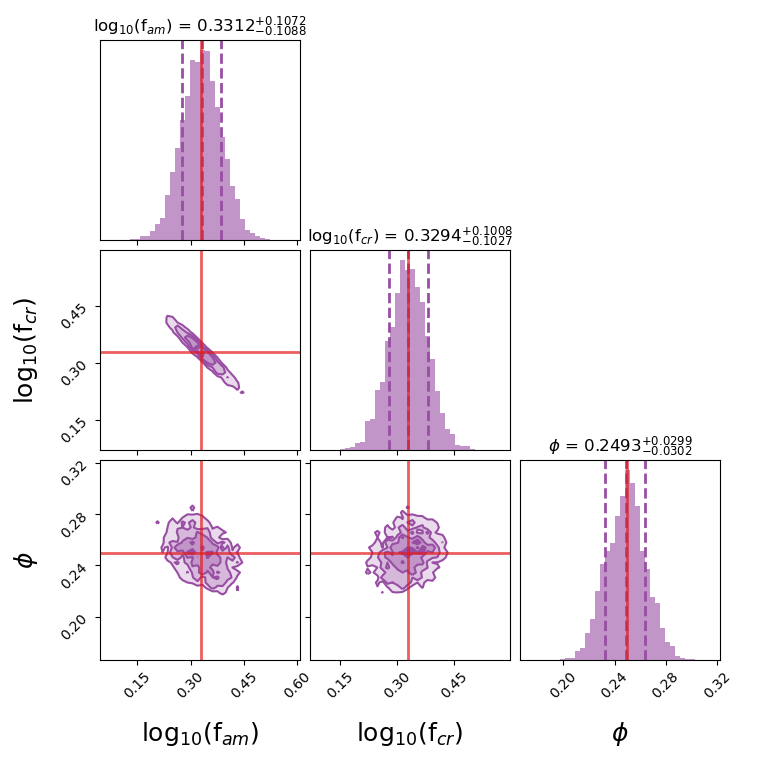

In [21]:
# plot posteriors

labels=['log$_{10}$(f$_{am}$)','log$_{10}$(f$_{cr}$)','$\phi$']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                              title_fmt='.4f',truths=[f_am_true,f_cr_true, phi_true],truth_color='#e41a1c',
                              label_kwargs={'fontsize':label_font}, hist2d_kwargs={'plot_contours':True,'fill_contours':True});

<IPython.core.display.Javascript object>


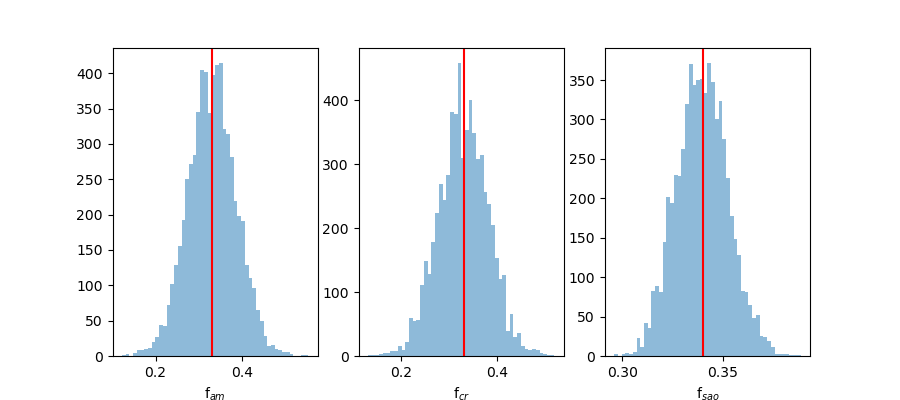

In [22]:
# plot all posterior for all abundances

# draw posterior samples
weights = np.exp(sampler.results['logwt'] - sampler.results['logz'][-1])
samples_mod = resample_equal(sampler.results['samples'], weights)

# draw properly weighted posterior samples

weights = np.exp(sampler.results['logwt'] - sampler.results['logz'][-1])
samples_mod = resample_equal(sampler.results['samples'], weights)

f_am_list, f_cr_list, f_sao_list = [], [], []

for i in range(samples_mod.shape[0]):
    f_am = samples_mod[i,0]
    f_cr = samples_mod[i,1]
    f_sao = 1 - f_am - f_cr
    f_am_list.append(f_am)
    f_cr_list.append(f_cr)
    f_sao_list.append(f_sao)
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))

ax[0].hist(f_am_list, alpha=0.5, bins=50)
ax[0].set_xlabel('f$_{am}$')
ax[0].axvline(x=f_am_true, c='r')

ax[1].hist(f_cr_list, alpha=0.5, bins=50)
ax[1].set_xlabel('f$_{cr}$')
ax[1].axvline(x=(f_cr_true), c='r')

ax[2].hist(f_sao_list, alpha=0.5, bins=50)
ax[2].set_xlabel('f$_{sao}$')
ax[2].axvline(x=(f_sao_true), c='r')

#### Three component retrieval with Jeffery's prior on abundances, and $f_{sao} = 1 - f_{am} - f_{cr}$. 
#### Three free parameters: $f_{am}$, $f_{cr}$ and $\phi$

In [24]:
# Perform Bayesian retrieval using a multi component model

# set bounds for priors on free-parameters: log10f_am, log10f_cr, phi

bounds = [(-3,0),(-3,0), (0.01,0.52)]


def prior_trans_2comp(theta,prior_bounds=bounds):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)
    
    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.
        
    Returns
    -------
    
    tuple containing all the transformed free parameter values
    """
    
    transformed = ()
    
    for i,param_prime in enumerate(theta):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]
        
        param = param_prime*(param_max - param_min) + param_min
        
        transformed += (param,)
        
    return transformed

def loglik_2comp(theta):
    """
    The log-likelihood function.
    """

    log10f_am, log10f_cr, phi = theta # unpack the parameters
    
    if (10**log10f_am + 10**log10f_cr) < 1:
    
        f_sao = 1 - 10**log10f_am - 10**log10f_cr
        
        K = rad_tran.get_K(phi)
    
        # the fixed parameters are global and have been defined earlier in the notebook

        am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':10**log10f_am,'p_type':'HG2'}
        cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':10**log10f_cr,'p_type':'HG2'}
        sao_dict = {'n':n_sao,'k':k_sao,'wav':wav_sao,'log10D':log10D_sao_true, 'f':f_sao,'p_type':'HG2'}

        param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp_dict_list':[am_dict, cr_dict, sao_dict]}

        model, wav_model = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

        # reduce model to data's resolution
        
        final = bintools.binning(wav_model,model,newx=wav_syn)
        model, wav_model = final['bin_y'],final['bin_x']
        
        # check that noise is an array (to evaluate norm_log correctly)

        if not(isinstance(noise_syn, np.ndarray)):
            raise TypeError('noise variable should be a numpy array') 

        norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise_syn)**2))

        chisq = -0.5*np.sum((model-data_syn)**2/(noise_syn)**2)

        return chisq + norm_log
    
    else:
        return -100.

In [25]:
nlive = 512       # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3         # four parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler = NestedSampler(loglik_2comp, prior_trans_2comp, ndims,
                        bound=bound, sample=sample, nlive=nlive,pool=pool, queue_size=Nproc)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=True)
t1 = time()

timedynesty = (t1-t0)

hours,minutes,seconds = utils.get_hms(timedynesty)

print("Time taken to run 'dynesty' (multiprocessing) is {} hours {} minutes {} seconds".format(hours,minutes,seconds))

iter: 6311 | +512 | bound: 26 | nc: 1 | ncall: 38835 | eff(%): 17.569 | loglstar:   -inf < 701.071 <    inf | logz: 691.096 +/-  0.184 | dlogz:  0.000 >  0.100                                       

Time taken to run 'dynesty' (multiprocessing) is 0.0 hours 2.0 minutes 11.260552883148193 seconds


<IPython.core.display.Javascript object>


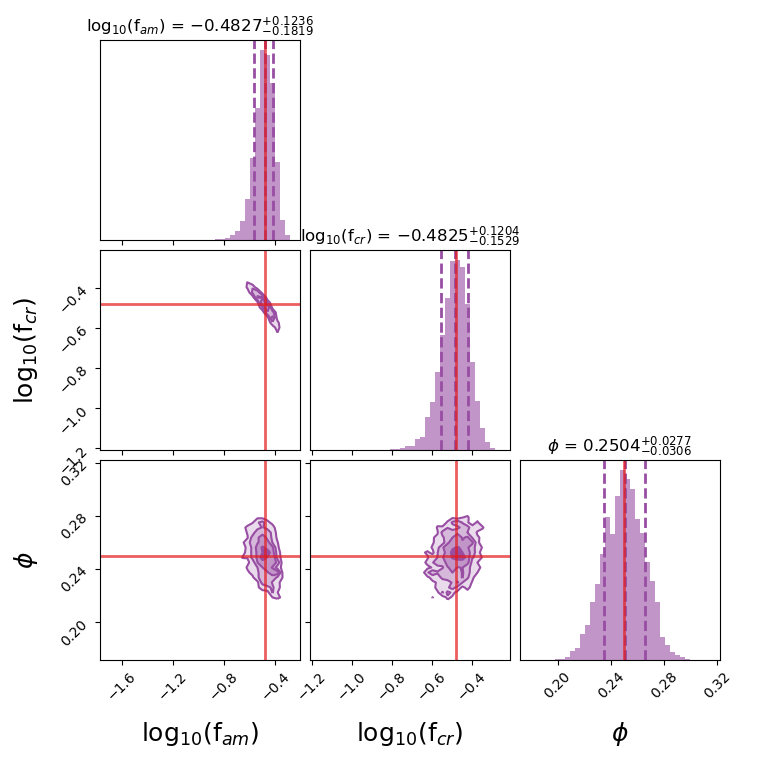

(<Figure size 760x760 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36b6e063d0>,
       dtype=object))

In [26]:
# plot posteriors

labels=['log$_{10}$(f$_{am}$)','log$_{10}$(f$_{cr}$)','$\phi$']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                              title_fmt='.4f',truths=[np.log10(f_am_true),np.log10(f_cr_true),phi_true],truth_color='#e41a1c',
                              label_kwargs={'fontsize':label_font}, hist2d_kwargs={'plot_contours':True,'fill_contours':True})

<IPython.core.display.Javascript object>


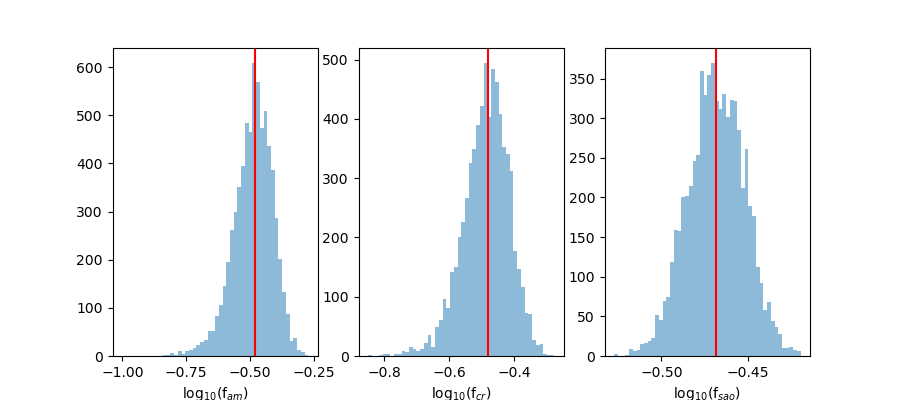

In [27]:
# draw properly weighted posterior samples

weights = np.exp(sampler.results['logwt'] - sampler.results['logz'][-1])
samples_mod = resample_equal(sampler.results['samples'], weights)

log10f_am_list, log10f_cr_list, log10f_sao_list = [], [], []

for i in range(samples_mod.shape[0]):
    log10f_am = samples_mod[i,0]
    log10f_cr = samples_mod[i,1]
    log10f_sao = np.log10(1 - 10**log10f_am - 10**log10f_cr)
    log10f_am_list.append(log10f_am)
    log10f_cr_list.append(log10f_cr)
    log10f_sao_list.append(log10f_sao)
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))

ax[0].hist(log10f_am_list, alpha=0.5, bins=50)
ax[0].set_xlabel('log$_{10}$(f$_{am}$)')
ax[0].axvline(x=np.log10(f_am_true), c='r')

ax[1].hist(log10f_cr_list, alpha=0.5, bins=50)
ax[1].set_xlabel('log$_{10}$(f$_{cr}$)')
ax[1].axvline(x=np.log10(f_cr_true), c='r')

ax[2].hist(log10f_sao_list, alpha=0.5, bins=50)
ax[2].set_xlabel('log$_{10}$(f$_{sao}$)')
ax[2].axvline(x=np.log10(f_sao_true), c='r')

#### Re-run the same retrieval but now with Dirichlet prior

In [4]:
# Perform Bayesian retrieval using a multi component model

# set bounds for priors on free-parameters: log10f_am, log10f_cr, phi

n_species = 3
bounds = [(-3.,0),(-3.,0),(0.01,0.52)]

def Dirichlet_Prior(params, lower_bound, n_species):
    
    ''' Impliments a Dirchlet prior for chemical mixing ratios.
    
        Dir[i] here is the centred log-ratio transform of the mixing ratio, X[i]
       
    '''
    
    n = n_species   # Number of species free parameters
    limit = lower_bound           # Lowest (log) mixing ratio considered

    # Limits correspond to condition that all X_i > 10^(limit)
    prior_lower_Dir = ((n-1.0)/n) * (limit * np.log(10.0) + np.log(n-1.0))      # Lower limit corresponds to species underabundant
    prior_upper_Dir = ((1.0-n)/n) * (limit * np.log(10.0))                      # Upper limit corresponds to species dominant

    Dir = np.zeros(shape=(n))   # Vector of log ratio parameters
    X = np.zeros(shape=(n))     # Vector of mixing ratio parameters
    
    # Evalaute centred log-ratio parameters by uniformly sampling between limits
    for i in range(n-1):
 
        Dir[1+i] = ((params[i] * (prior_upper_Dir - prior_lower_Dir)) + prior_lower_Dir) 
          
    if (np.abs(np.sum(Dir[1:n])) <= prior_upper_Dir):   # Impose same prior on X_0
    #if 1==1:
            
        Dir[0] = -1.0*np.sum(Dir[1:n])   # Dir_n (corresponding to mixing ratio of first species) must equal 0, so that X_i sum to 1
        
        if ((np.max(Dir) - np.min(Dir)) <= (-1.0 * limit * np.log(10.0))):      # Necessary for all X_i > 10^(limit)    
        #if 1==1:
            
            normalisation = np.sum(np.exp(Dir))
        
            for i in range(n):
                
                # Map log-ratio parameters to mixing ratios
                X[i] = np.exp(Dir[i]) / normalisation   # Vector of mixing ratios (should sum to 1!)
                
                # One final check that all X_i > 10^(limit)
                if (X[i] < 10**limit): return (np.ones(n)*(-50.0))    # Fails check -> return dummy array of log values
            
            return np.log10(X)   # Return vector of log-mixing ratios
        
        elif ((np.max(Dir) - np.min(Dir)) > (-1.0 * limit * np.log(10.0))):
        
            return (np.ones(n)*(-50.0))   # Fails check -> return dummy array of log values
    
    elif (np.abs(np.sum(Dir[1:n])) > prior_upper_Dir):   # If falls outside of allowed triangular subspace
        
        return (np.ones(n)*(-50.0))    # Fails check -> return dummy array of log values
    
def prior_trans_2comp(theta,prior_bounds=bounds, n_species=n_species):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)
    
    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.
        
    Returns
    -------
    
    tuple containing all the transformed free parameter values
    """
    # first get the abundance values
    
    lower_bound = bounds[0][0]    # assuming all species have same lower bound on prior
    
    transformed = Dirichlet_Prior(theta[:n_species-1], lower_bound=lower_bound, n_species=n_species)
    
    # get other parameter values
    
    for i in range(n_species-1,len(theta)):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]
        
        param = theta[i]*(param_max - param_min) + param_min
        
        transformed = np.append(transformed,param)
        
    return transformed



def loglik_2comp(theta):
    """
    The log-likelihood function.
    """
    if np.all(theta[:n_species] != np.ones(3)*(-50.0)):
        log10f_sao, log10f_am, log10f_cr, phi = theta[0], theta[1], theta[2], theta[3] # unpack the parameters
        
        K = rad_tran.get_K(phi)

        # the fixed parameters are global and have been defined earlier in the notebook

        am_dict = {'n':n_am,'k':k_am,'wav':wav_am,'log10D':log10D_am_true, 'f':10**log10f_am,'p_type':'HG2'}
        cr_dict = {'n':n_cr,'k':k_cr,'wav':wav_cr,'log10D':log10D_cr_true, 'f':10**log10f_cr,'p_type':'HG2'}
        sao_dict = {'n':n_sao,'k':k_sao,'wav':wav_sao,'log10D':log10D_sao_true, 'f':10**log10f_sao,'p_type':'HG2'}

        param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp_dict_list':[am_dict, cr_dict, sao_dict]}

        model, wav_model = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

        # reduce model to data's resolution

        final = bintools.binning(wav_model,model,newx=wav_syn)
        model, wav_model = final['bin_y'],final['bin_x']

        # check that noise is an array (to evaluate norm_log correctly)

        if not(isinstance(noise_syn, np.ndarray)):
            raise TypeError('noise variable should be a numpy array') 

        norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise_syn)**2))

        chisq = -0.5*np.sum((model-data_syn)**2/(noise_syn)**2)

        return chisq + norm_log
    
    else:
        return -100.

In [5]:
nlive = 512       # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3         # three parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler = NestedSampler(loglik_2comp, prior_trans_2comp, ndims,
                        bound=bound, sample=sample, nlive=nlive,pool=pool, queue_size=Nproc)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=True)
t1 = time()

timedynesty = (t1-t0)

hours,minutes,seconds = utils.get_hms(timedynesty)

print("Time taken to run 'dynesty' (multiprocessing) is {} hours {} minutes {} seconds".format(hours,minutes,seconds))

iter: 7106 | +512 | bound: 21 | nc: 1 | ncall: 40459 | eff(%): 18.829 | loglstar:   -inf < 701.071 <    inf | logz: 689.544 +/-  0.200 | dlogz:  0.000 >  0.100                                       

Time taken to run 'dynesty' (multiprocessing) is 0.0 hours 2.0 minutes 23.1402325630188 seconds


<IPython.core.display.Javascript object>


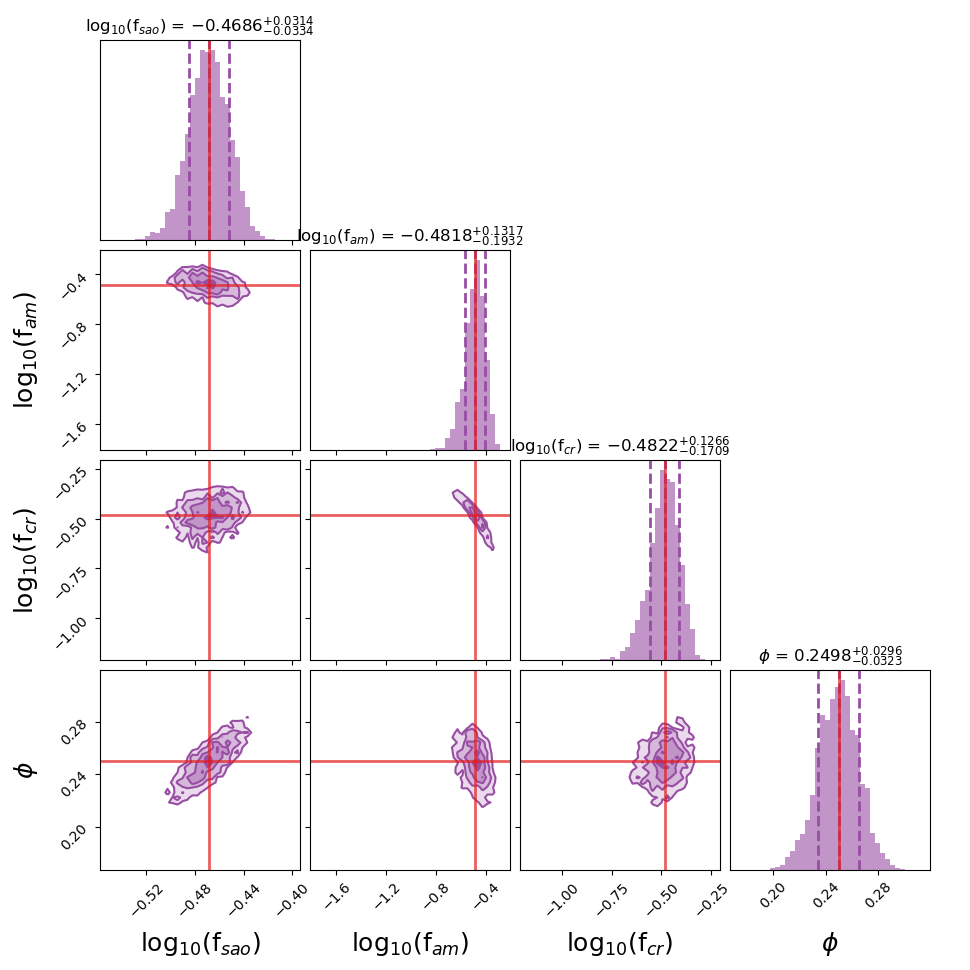

In [7]:
# plot posteriors

labels=['log$_{10}$(f$_{sao}$)','log$_{10}$(f$_{am}$)','log$_{10}$(f$_{cr}$)', '$\phi$']
quantiles= [0.1587, 0.5, 0.8413]    # +/- 1 sigma interval
label_font = 18

dyplot.cornerplot(sampler.results, quantiles=quantiles,smooth=40, color='#984ea3',show_titles=True,labels=labels,
                              title_fmt='.4f',truths=[np.log10(f_sao_true),np.log10(f_am_true),np.log10(f_cr_true),phi_true],
                  truth_color='#e41a1c',label_kwargs={'fontsize':label_font}, hist2d_kwargs={'plot_contours':True,'fill_contours':True});